In [1]:
import os
import re
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/jovyan/india-research/data/final_df.csv')
df.head(5)

,likes,replies,retweets,text,timestamp,url
0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...
1,1,0,0,Please share city name. Thanks!,2023-09-17 19:58:00+00:00,https://twitter.com/BloodDonorsIn/status/17034...
2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...
3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...
4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...


In [3]:
# TASK 1: let's extract city names from text columns
df['city'] = df['text'].str.extract(r'#(\w+)', expand = False)

# delete SOS and NaN values. As we do this, we also get rid of values like "Some fields are missing."
df = df[df['city'] != 'SOS']
df.dropna(subset = ['city'], inplace = True)

# set all cities to lowercase to avoid duplicates
df['city'] = df['city'].str.lower()

# delete values that are numbers
df = df[df['city'].str[0] != '9']
df.head(5)

,likes,replies,retweets,text,timestamp,url,city
0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,mohali
2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,lucknow
3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,delhi
4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,jabalpur
5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,delhi


In [4]:
# import real cities in India
real_cities = pd.read_excel('/home/jovyan/india-research/data/worldcities.xlsx')
real_cities = real_cities[real_cities['country'] == 'India'].loc[:, 'city'].str.lower()

# let's normalize real city names so all letters are from english alphabet
def normalize_city_name(city_name):
    normalized_name = ''.join([c for c in unicodedata.normalize('NFD', city_name) if not unicodedata.combining(c)])
    normalized_name = ' '.join(normalized_name.split())
    normalized_name = normalized_name.lower()
    return normalized_name

real_cities = real_cities.apply(normalize_city_name)

In [5]:
# let's create two lists, one of which contains cities that are real cities in India, while the other contains 
# either non-real cities (villages, etc.) or misspelled cities. I'll handle the second case in the following
# using the Levenshtein distance function.
est = []
netu = []
cities = df['city'].unique()
for i in range(len(cities)):
    if cities[i] in real_cities.values:
        est.append(cities[i])
    else:
        netu.append(cities[i])

In [6]:
def levenshtein_distance(s1, s2):
    matrix = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        matrix[i][0] = i
    for j in range(len(s2) + 1):
        matrix[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,
                matrix[i][j - 1] + 1,
                matrix[i - 1][j - 1] + cost)

    return matrix[-1][-1]

dict = {}
for city in netu:
    for real in est:
        if levenshtein_distance(city, real) <= 1:
            dict[city] = real
            continue

In [7]:
# add the following key and value to dict to replace
dict['new'] = 'new delhi'

df['city'] = df['city'].replace(dict)
df.reset_index(inplace = True)
df

,index,likes,replies,retweets,text,timestamp,url,city
0,0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,mohali
1,2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,lucknow
2,3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,delhi
3,4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,jabalpur
4,5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,delhi
...,...,...,...,...,...,...,...,...
26859,70928,6,0,29,#Patna\nNeed #Blood Type : B-positive\nBlood ...,2021-07-02 06:01:00+00:00,https://twitter.com/BloodDonorsIn/status/14108...,patna
26860,70929,9,0,37,#Bhubaneswar \nNeed #Blood Type : O-negative\...,2021-07-02 05:58:00+00:00,https://twitter.com/BloodDonorsIn/status/14108...,bhubaneshwar
26861,70932,8,1,32,#Nagercoil\nNeed #Blood Type : O-negative\nBl...,2021-07-02 05:53:00+00:00,https://twitter.com/BloodDonorsIn/status/14108...,nagercoil
26862,70937,6,0,27,#New Dehli\nNeed #Blood Type : O-positive\nBl...,2021-07-02 05:43:00+00:00,https://twitter.com/BloodDonorsIn/status/14108...,new delhi


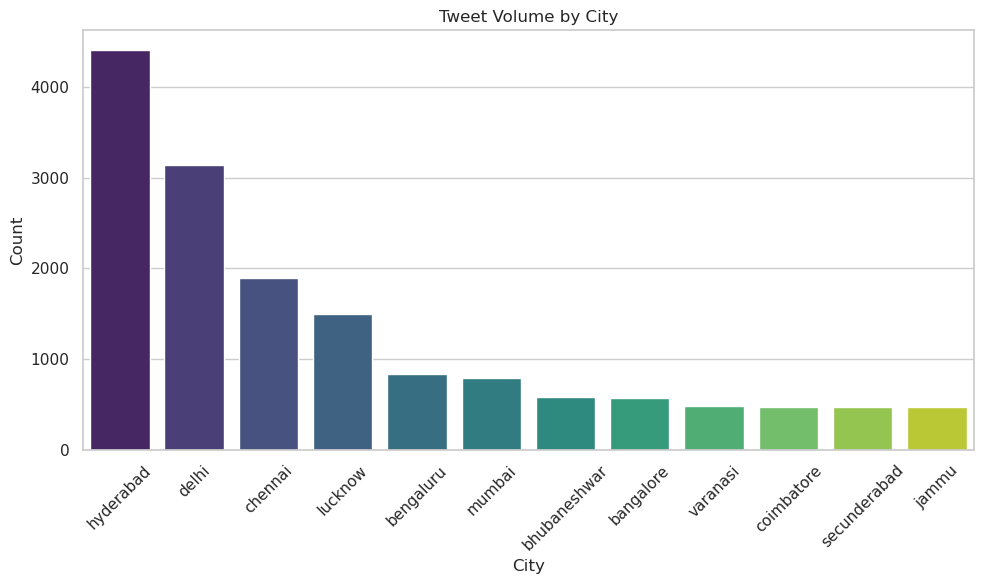

In [8]:
# TASK 4: visualizing tweet volume by cities, specifically, visualizing top-12 cities
city_counts = df['city'].value_counts()
top_cities = city_counts.head(12)

sns.set(style = "whitegrid")
plt.figure(figsize = (10, 6))

sns.barplot(x = top_cities.index, y = top_cities.values, palette = "viridis")
plt.title('Tweet Volume by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [9]:
# TASK 2: let's now extract blood groups from text columns using regex
pattern = r'\b([ABO][+-]?|AB[+-]?|Any group)\b'
df['blood_group'] = df['text'].str.extract(pattern, flags = re.IGNORECASE)

# Handle the case when "Any group" is mentioned and actual blood group is not given
df.loc[df['text'].str.contains('Any group', case = False), 'blood_group'] = 'Any'

df.head(5)

,index,likes,replies,retweets,text,timestamp,url,city,blood_group
0,0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,mohali,B+
1,2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,lucknow,Any
2,3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,delhi,Any
3,4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,jabalpur,AB-
4,5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,delhi,B+


In [10]:
dict = {'a': 'A', 'Ab-': 'AB-', 'b+': 'B+', 'o': 'O'}
df['blood_group'] = df['blood_group'].replace(dict)
df['blood_group'].value_counts()

O-     6633
B-     5901
A-     5349
Any    4030
AB-    2973
O+      388
B+      364
A+      344
AB+     196
A        46
O        41
B        27
AB       17
Name: blood_group, dtype: int64

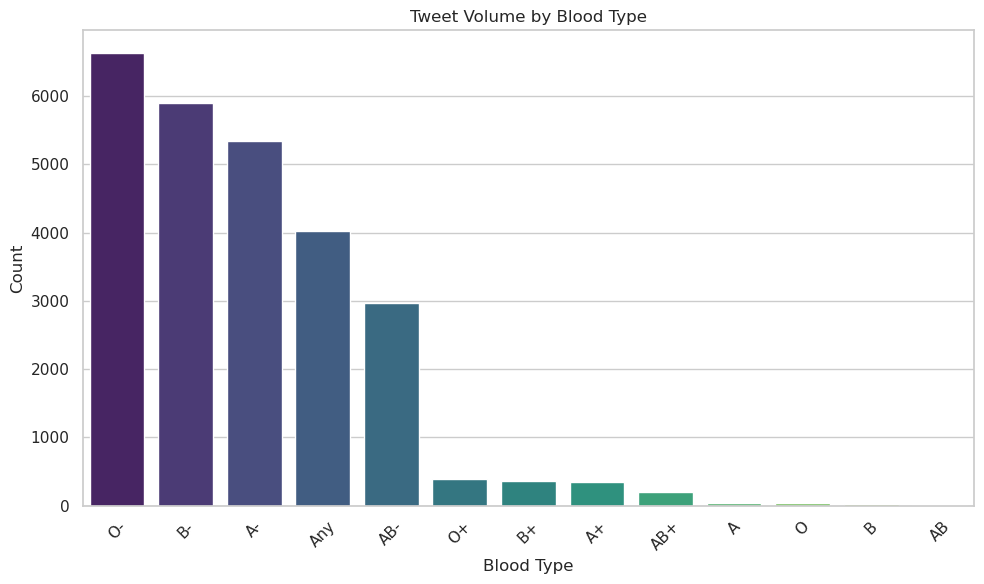

In [11]:
# Let's make the same visualization but studying most popularly-asked blood types 
blood_groups = df['blood_group'].value_counts()

sns.set(style = "whitegrid")
plt.figure(figsize = (10, 6))

sns.barplot(x = blood_groups.index, y = blood_groups.values, palette = "viridis")
plt.title('Tweet Volume by Blood Type')
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

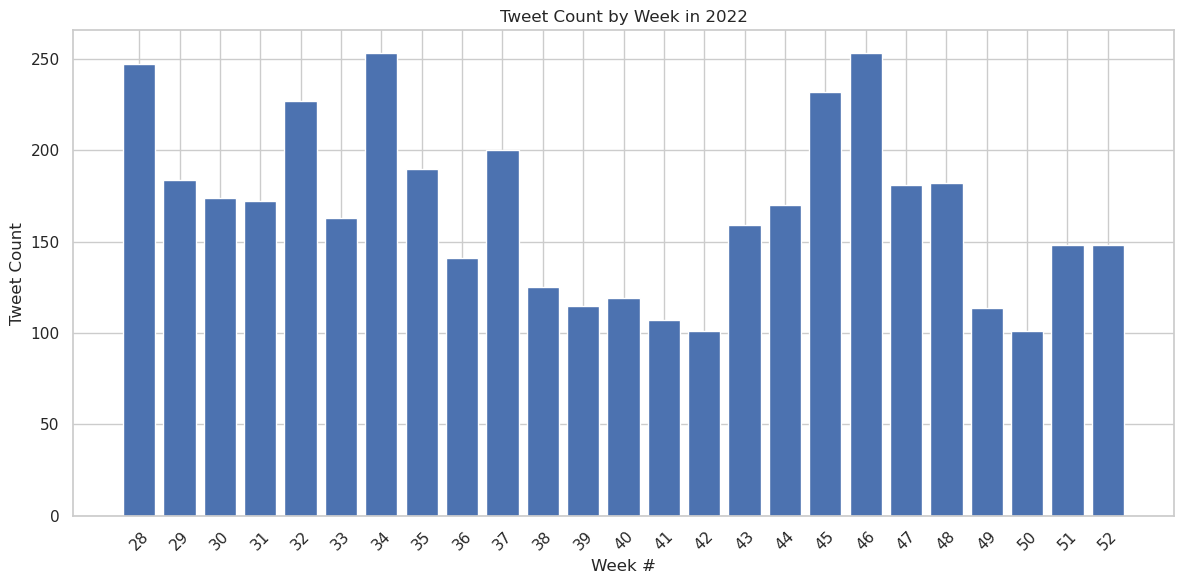

In [37]:
# TASK 3: let's now analyze tweets weekly over the course of the year
# Note: at the top of this notebook, we dropped all tweets that didn't have cities in their text. Most of them contained
# text like "Some fields are missing." Nevertheless, the following visualization of tweet volume is made using same df
df['timestamp'] = pd.to_datetime(df['timestamp'])

df_2022 = df[df['timestamp'].dt.year == 2022].copy()
df_2022['week'] = df_2022['timestamp'].dt.strftime('%U')

tweet_counts_by_week = df_2022['week'].value_counts().sort_index()

plt.figure(figsize = (12, 6))
plt.bar(tweet_counts_by_week.index, tweet_counts_by_week.values)
plt.xlabel('Week #')
plt.ylabel('Tweet Count')
plt.title('Tweet Count by Week in 2022')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

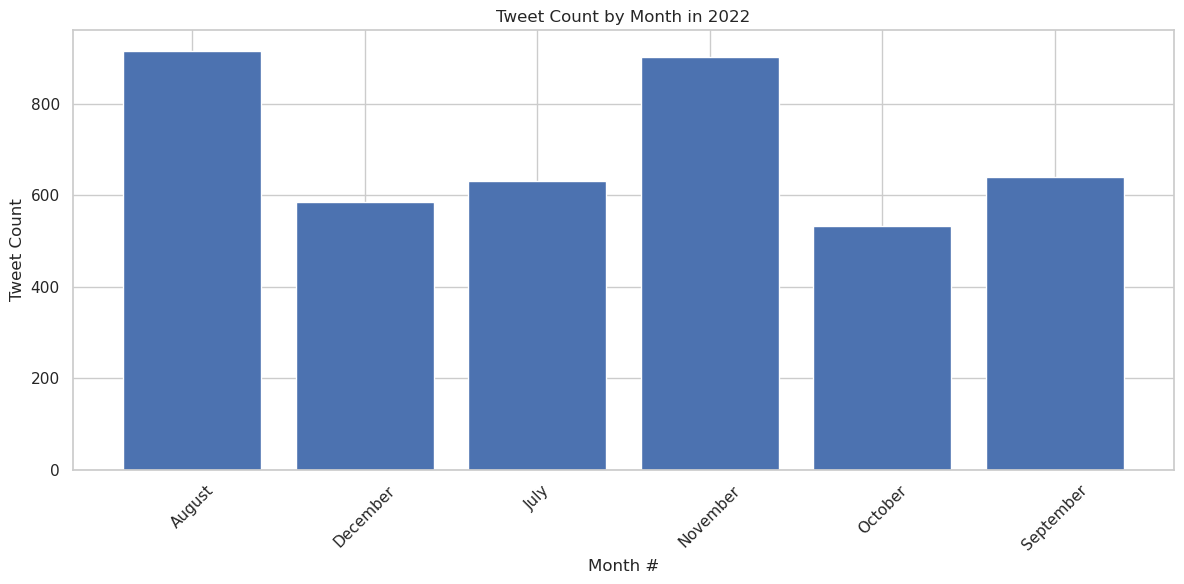

In [38]:
# The following visualization is not weekly but monthly
df['timestamp'] = pd.to_datetime(df['timestamp'])

df_2022 = df[df['timestamp'].dt.year == 2022].copy()
df_2022['month'] = df_2022['timestamp'].dt.strftime('%B')

tweet_counts_by_month = df_2022['month'].value_counts().sort_index()

plt.figure(figsize = (12, 6))
plt.bar(tweet_counts_by_month.index, tweet_counts_by_month.values)
plt.xlabel('Month #')
plt.ylabel('Tweet Count')
plt.title('Tweet Count by Month in 2022')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()